# **Speech Emotion Recogition (Classification) in real-time using Deep LSTM layers**
### ***A Deep Learning LSTM based model with keras.***
---

### Final project (B.Sc. requirement)  
Development by **Meidan Greenberg & Linoy Hadad.**

Instructor: **Dr. Dima Alberg**

Industial Engineering and Management dept.

SCE Collage, Israel.





# **ABSTRACT**


---



# **LIBRARIES & GOOGLE AUTH**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [1]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [2]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

# **THE DATA**
The speech emotion audio databases used:

- **The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**
https://zenodo.org/record/1188976#.X4sE0tDXKUl
  - The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) was recorded with 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. 
  - **1440 files** = 24 actors x 60 trails per actor
  - **8 Emotions** (neutral, calm, happy, sad, angry, fearful, disgust, surprised).

- **Toronto Emotional Speech Set (TESS)**
https://tspace.library.utoronto.ca/handle/1807/24487
  - These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions described below.
Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.
  - **2800 files** = 2 actors x 200 pharses x 7 emotions
  - **7 Emotions** (neutral, happiness, sadness, anger, fear, disgust, pleasant surprise)
   - ('calm' is not a part of this DB)


# **DATA PREPROCESSING**

The preprocessing is described in the following diagram.
![SER_Diagram.png]


(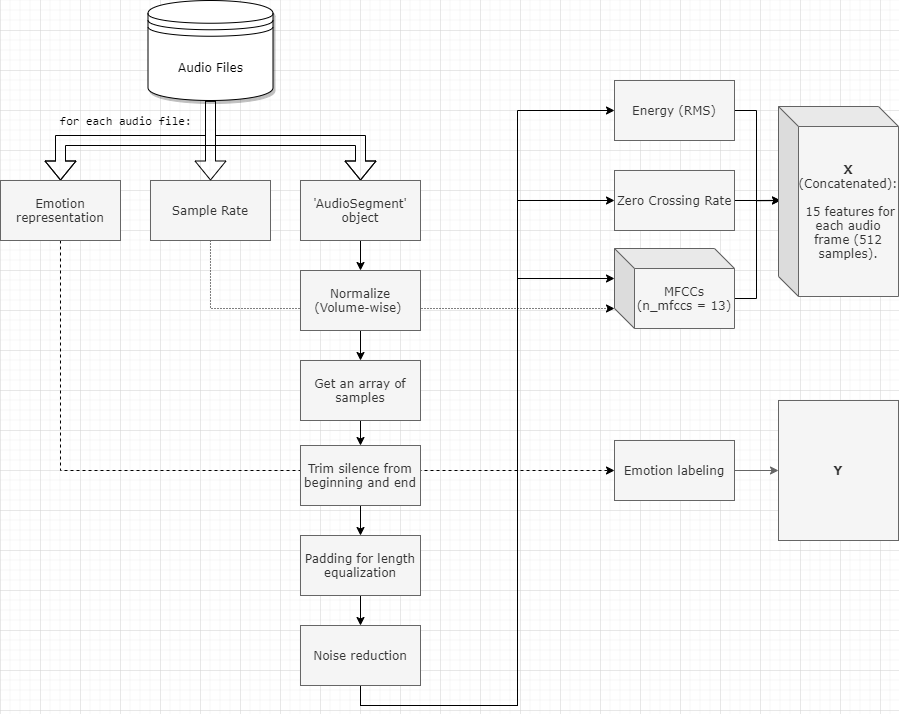)

## **Initial extractions**
The following data is extracted from each audio file:
1.   **Emotion representation**

    *   RAVDESS: The filename contains a fixed placed int that represents an emotion, e.g. 03 is happy.
    *   TESS: The filename contains a string representation of an emotion, e.g 'happy'.


2.   **Sample Rate**: number of audio samples per second. RAVDESS database was recorded in 48kHz, and the TESS database was recorded in 24.414kHz. 

3. **The audio** is processed in the following order:


*   'AudioSegment' instance: The audio is loaded to an object by the `AudioSegment` module of `pydub`.
*   Normalization: The 'AudioSegment' object is normalized to + 5.0 dBFS, by `effects` module of `pydub`. 
*   Transforming the object to an array of samples by `numpy` & `AudioSegment`.
*   Trimming the silence in the beginning and the end by `librosa`.
*   Padding every audio file to the maximum length by `numpy`, for length equalization.
*   Noise reduction is being performed by `noisereduce`.
---
















## **Features extraction**
The selected features being extracted with `librosa` for the speech emotion recognition model are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs) 

With `frame_length = 2048`, `hop_lentgh = 512`, assuring equally sequential length. 

**Explanation:**

Every 2048 samples (sequence of ~0.058 seconds on average) are being analyzed and translated to 4 sequential feature values (2048 / 512 = 4). 

In total, for an audio file lengthed 173056 samples, considering the last sample, 339 sequential values are returned for each feature  (173056+1 / 512 = 339).

Audio preprocess and feature extraction is presented for a single audio file in "1_preprocess_for_one_audiofile" notebook.

## **Emotion representation**
There is a different representation of the emotions in each database.

#### **RAVDESS Database**

*   A RAVDESS filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). The format which carries only emotion expressed by speech is taken as 03-01-X-X-X-X-X.wav, as the 8 emotions are stated in the 3rd part (The 1st 'X' within the file-name format).

 
#### **TESS Database**

*   A TESS file name contains the emotion by a direct text, e.g. "YAF_youth_happy.wav". 

*    To overcome this incompatibility with the RAVDESS representation, "find_emotion" function has been executed.


In addition, classification modeling accepting only values starting from zero, thus "emotionfix" function has been executed for all files, performing an 'n = n-1' process for the emotion representation.


In [3]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [5]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\SSD_Final_MusicEmotion\data\RAVDESS"

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))    

Maximum sample length: 204288


## **THE PREPROCESS**
Following the preprocessing presentation for a single audio file in "1_preprocess_for_one_audiofile" notebook, the full data will be preprocessed and extracted as the speech features chosen.

In [6]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

#folder_path = r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\MOs\ser-20230326T172522Z-001\sersid"
folder_path = r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\SSD_Final_MusicEmotion\data\RAVDESS"

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #if(total_length-len(xt)<0):  
      if(total_length-len(xt) < 0):
        continue
      #print(total_length-len(xt))
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
    # Pad for duration equalization.
      padded_x = abs(np.pad(xt, (0, total_length-len(xt)), 'constant'))+1
      
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]                      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 
      

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 9.5401 minutes


# **FINAL DATA SETUP**
In order to input the data into a model, a few adjustments should be made:


*   The shapes of the features must be uniform, and in the 3D format: 

 **(batch, timesteps, feature)**
*   Concatenating all features to a single 'X' variable.
*   Adjustment of 'Y' with a 2D shape (keras library requirement)
*   Split of X, Y to train, validation, and test sets.
*   y_train and y_validation conversion to 'One-hot' vectors for classification purposes (y_test is being converted adjacent to the test)




**X, Y Setup**

In [7]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (2874, 339, 1)
RMS shape: (2874, 339, 1)
MFCCs shape: (2874, 339, 13)


**Note: a total of 8 files had been removed from both databases due to various file corruptions.**

In [8]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

**Save & Load X,Y to JSON files**

In [9]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist() 
x_path = 'sersid/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = 'sersid/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)


'[[0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [4], [4], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [6], [6], [6], [6], [6], [6], [6], [6], [7], [7], [7], [7], [7], [7], [7], [7], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [4], [4], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [6], [6], [6], [6], [6], [6], [6], [6], [7], [7], [7], [7], [7], [7], [7], [7], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [4], [4], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [6], [6], [6], [6], [6], [6], [6], [6], [7], [7], [7], [7], [7], [7], [7], [7], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2]

In [10]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = 'sersid/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = 'sersid/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')


*   **Split X, Y To Train, Validation, and Test Sets**
*   **y_train and y_val conversion to One-Hot vectors.**



In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = to_categorical(y_train, 8, dtype = 'int8')
y_val_class = to_categorical(y_val, 8, dtype = 'int8')

In [13]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(2514, 339, 15)
(250, 339, 15)
(110, 339, 15)


In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(3703, 339, 15)
(368, 339, 15)
(161, 339, 15)


In [14]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[5], [6], [5], [1], [6], [1], [6], [7], [7], [4], [1], [2], [5], [7], [1], [3], [2], [1], [7], [7], [6], [1], [1], [1], [2], [5], [5], [5], [6], [2], [5], [2], [5], [3], [2], [7], [0], [5], [4], [7], [3], [2], [5], [4], [6], [1], [1], [7], [6], [2], [7], [4], [3], [3], [4], [5], [1], [2], [4], [5], [1], [4], [0], [5], [1], [2], [3], [6], [5], [5], [3], [6], [0], [3], [0], [2], [7], [6], [4], [0], [3], [3], [5], [3], [4], [5], [7], [4], [1], [4], [6], [1], [7], [1], [3], [4], [2], [2], [5], [7], [2], [7], [4], [0], [5], [7], [3], [6], [1], [7]], "dtype": "int8", "shape": [110, 1], "Corder": true}'

# **MODEL DEFINITION & TRAIN**
The model is executed with keras library, using 2 hidden LSTM layers with 64 nodes, and an output (dense) layer with 8 nodes, each for one emotion using the 'softmax' activation.
The optimizer that led to the best results was 'RMSProp' with default parameters.

The batch size chosen is 23, which is a factor of all samples in the sets; train (3703), validation (368) and test (161).

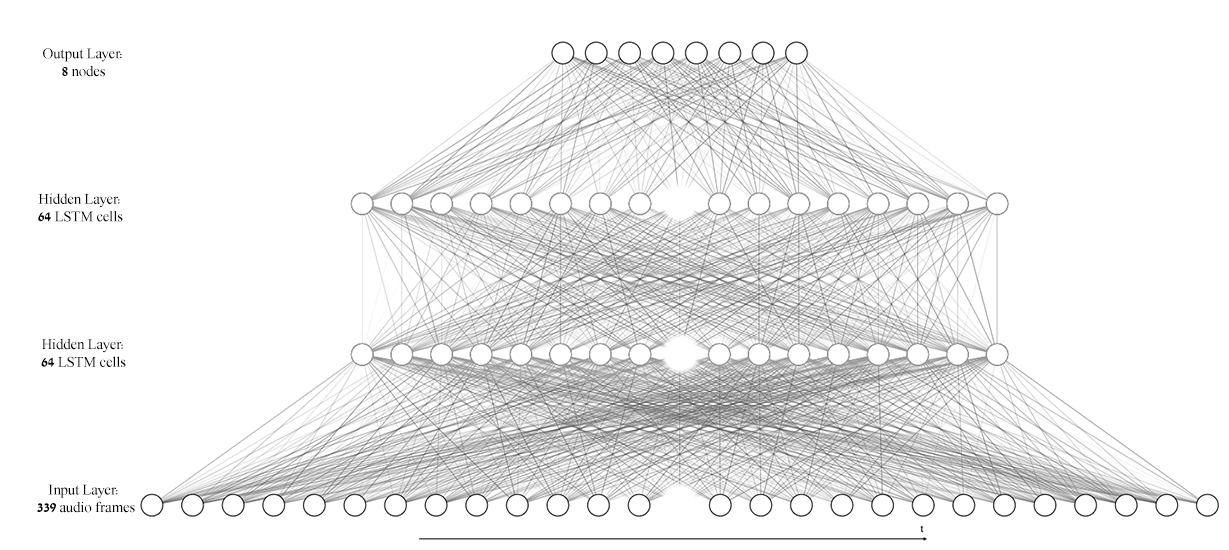

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 

# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 339, 64)           20480     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None


In [32]:

batch_size = 23

# Callbacks functions
checkpoint_path = 'data/RAVDESS/best_weights_ssd2.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 50 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=10)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=50, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Epoch 1/50
110/110 [==============================] - 11s 71ms/step - loss: 2.0714 - categorical_accuracy: 0.1408 - val_loss: 2.0421 - val_categorical_accuracy: 0.1600
Epoch 2/50
110/110 [==============================] - 7s 62ms/step - loss: 2.0366 - categorical_accuracy: 0.2017 - val_loss: 2.0597 - val_categorical_accuracy: 0.1600
Epoch 3/50
110/110 [==============================] - 7s 62ms/step - loss: 2.0255 - categorical_accuracy: 0.1877 - val_loss: 2.0375 - val_categorical_accuracy: 0.1680
Epoch 4/50
110/110 [==============================] - 7s 62ms/step - loss: 2.0134 - categorical_accuracy: 0.1917 - val_loss: 2.0435 - val_categorical_accuracy: 0.1800
Epoch 5/50
110/110 [==============================] - 7s 63ms/step - loss: 2.0084 - categorical_accuracy: 0.1997 - val_loss: 2.0180 - val_categorical_accuracy: 0.1840
Epoch 6/50
110/110 [==============================] - 7s 64ms/step - loss: 1.9918 - categorical_accuracy: 0.2116 - val_loss: 2.0145 - val_categorical_accuracy: 0.19

Epoch 50/50
110/110 [==============================] - 7s 62ms/step - loss: 1.1927 - categorical_accuracy: 0.5700 - val_loss: 1.4687 - val_categorical_accuracy: 0.4800


# Model Evaluation

**The model has been evaluated using the following factors:**


1.   A visualization of the loss and categorial accuracy values trend during the train process.
2.   A confusion matrix for visualizing the number of successful predictions of each emotion: for validation and test sets.
3.   Model's prediction accuracy rates for each emotion: for validation and test sets.


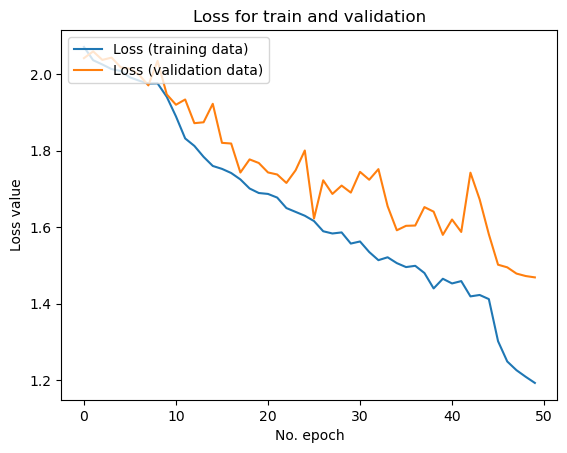

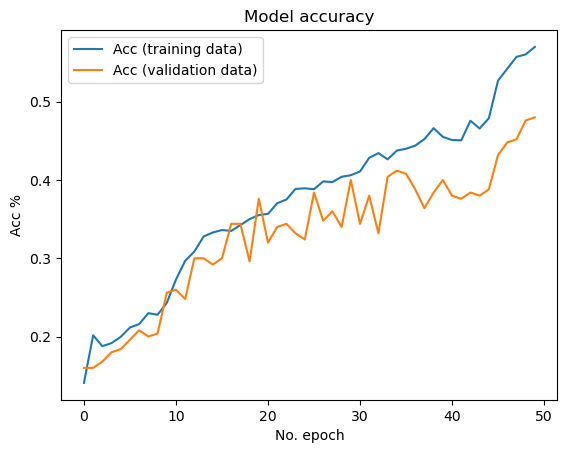

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [34]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

8/8 - 0s - loss: 1.4687 - categorical_accuracy: 0.4800


Text(0.5, 58.7222222222222, 'Predicted emotion')

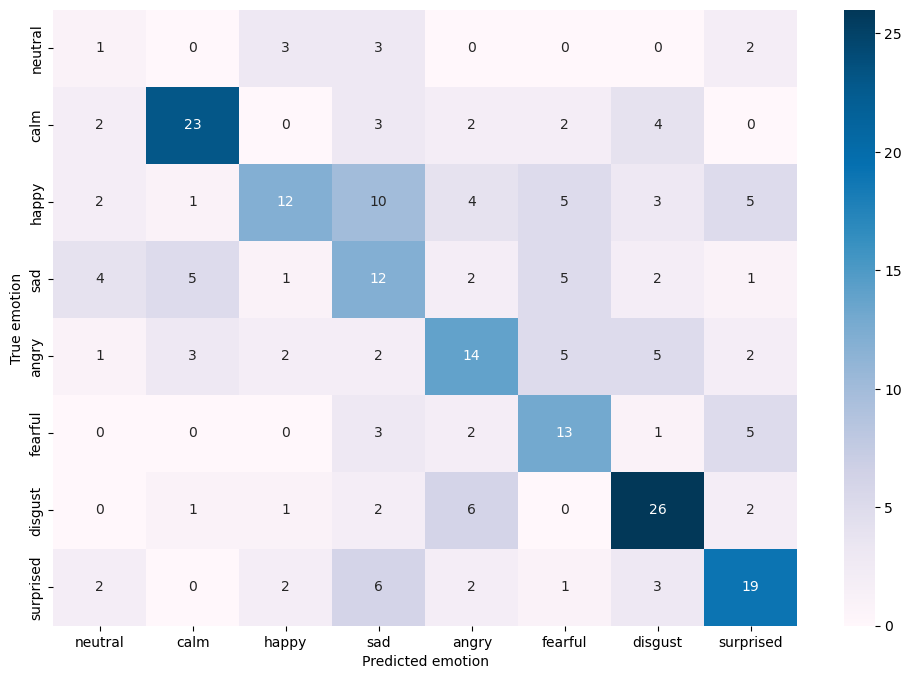

In [35]:
# Validation Confusion matrix
import pandas as pd
#y_val_class = np.argmax(y_val_class, axis=1)
yval=np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
#y_pred_class = np.argmax(predictions, axis=1)
ypred=np.argmax(predictions, axis=1)

#cm=confusion_matrix(y_val_class, y_pred_class)
cm=confusion_matrix(yval, ypred)
index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [36]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.1111
calm : 0.6389
happy : 0.2857
sad : 0.3750
angry : 0.4118
fearful : 0.5417
disgust : 0.6842
surprised : 0.5429


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 

In [16]:
# Initializing the model

model3 = Sequential()
model3.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model3.add(layers.LSTM(64))
model3.add(layers.Dense(8, activation = 'softmax'))
print(model3.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 339, 64)           20480     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model3, to_file='model_CNN.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [18]:

batch_size = 23

# Callbacks functions
checkpoint_path = 'sersid/best_weights_ssd.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=150)
                             
# Compile & train   
model3.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model3.fit(x_train, y_train_class, 
                      epochs=200, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model3.load_weights(checkpoint_path)

Epoch 1/200
110/110 [==============================] - 14s 71ms/step - loss: 2.0600 - categorical_accuracy: 0.1639 - val_loss: 2.0137 - val_categorical_accuracy: 0.1920
Epoch 2/200
110/110 [==============================] - 7s 65ms/step - loss: 2.0319 - categorical_accuracy: 0.1806 - val_loss: 2.0366 - val_categorical_accuracy: 0.1480
Epoch 3/200
110/110 [==============================] - 7s 63ms/step - loss: 2.0008 - categorical_accuracy: 0.2056 - val_loss: 2.0078 - val_categorical_accuracy: 0.1880
Epoch 4/200
110/110 [==============================] - 7s 62ms/step - loss: 1.9530 - categorical_accuracy: 0.2418 - val_loss: 2.0081 - val_categorical_accuracy: 0.2200
Epoch 5/200
110/110 [==============================] - 7s 64ms/step - loss: 1.9338 - categorical_accuracy: 0.2411 - val_loss: 1.9621 - val_categorical_accuracy: 0.2320
Epoch 6/200
110/110 [==============================] - 7s 65ms/step - loss: 1.9206 - categorical_accuracy: 0.2506 - val_loss: 1.9340 - val_categorical_accuracy

110/110 [==============================] - 7s 62ms/step - loss: 1.2747 - categorical_accuracy: 0.5354 - val_loss: 1.5733 - val_categorical_accuracy: 0.4080
Epoch 98/200
110/110 [==============================] - 7s 62ms/step - loss: 1.2639 - categorical_accuracy: 0.5342 - val_loss: 1.5205 - val_categorical_accuracy: 0.4440
Epoch 99/200
110/110 [==============================] - 7s 62ms/step - loss: 1.2443 - categorical_accuracy: 0.5513 - val_loss: 1.5765 - val_categorical_accuracy: 0.4200
Epoch 100/200
110/110 [==============================] - 7s 63ms/step - loss: 1.2713 - categorical_accuracy: 0.5362 - val_loss: 1.4869 - val_categorical_accuracy: 0.4520
Epoch 101/200
110/110 [==============================] - 7s 63ms/step - loss: 1.2304 - categorical_accuracy: 0.5438 - val_loss: 1.7046 - val_categorical_accuracy: 0.3840
Epoch 102/200
110/110 [==============================] - 7s 64ms/step - loss: 1.2457 - categorical_accuracy: 0.5414 - val_loss: 1.3899 - val_categorical_accuracy: 0.4

110/110 [==============================] - 7s 63ms/step - loss: 0.5622 - categorical_accuracy: 0.8146 - val_loss: 1.0299 - val_categorical_accuracy: 0.6480
Epoch 194/200
110/110 [==============================] - 7s 62ms/step - loss: 0.5579 - categorical_accuracy: 0.8011 - val_loss: 0.8917 - val_categorical_accuracy: 0.6840
Epoch 195/200
110/110 [==============================] - 7s 63ms/step - loss: 0.4703 - categorical_accuracy: 0.8401 - val_loss: 0.8574 - val_categorical_accuracy: 0.7400
Epoch 196/200
110/110 [==============================] - 7s 62ms/step - loss: 0.5385 - categorical_accuracy: 0.8158 - val_loss: 0.8134 - val_categorical_accuracy: 0.7360
Epoch 197/200
110/110 [==============================] - 7s 64ms/step - loss: 0.4786 - categorical_accuracy: 0.8341 - val_loss: 0.9322 - val_categorical_accuracy: 0.7200
Epoch 198/200
110/110 [==============================] - 7s 64ms/step - loss: 0.4655 - categorical_accuracy: 0.8377 - val_loss: 0.8356 - val_categorical_accuracy: 0

# **MODEL EVALUATION**
The model has been evaluated using the following factors:


1.   A visualization of the loss and categorial accuracy values trend during the train process.
2.   A confusion matrix for visualizing the number of successful predictions of each emotion: for validation and test sets.
3.   Model's prediction accuracy rates for each emotion: for validation and test sets.


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## **Train (fit) Visualization**

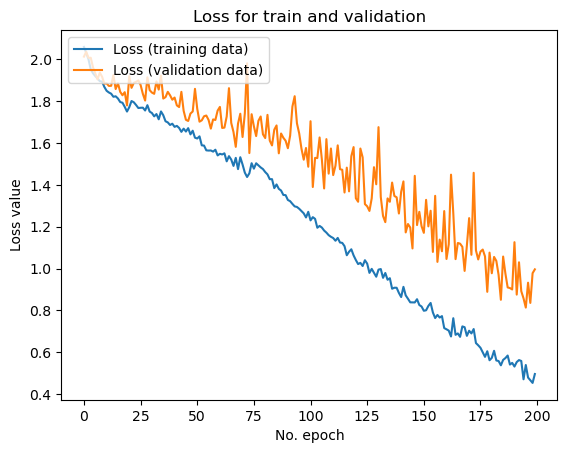

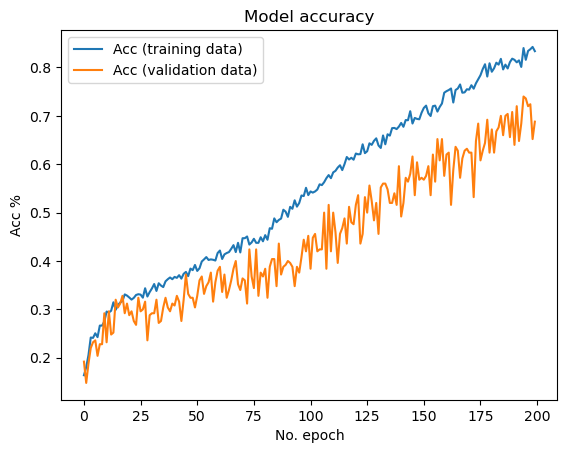

In [20]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

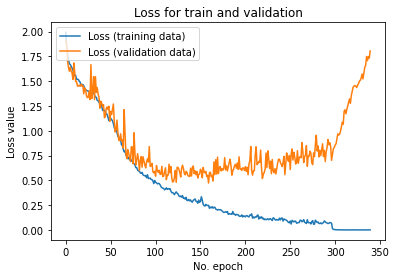

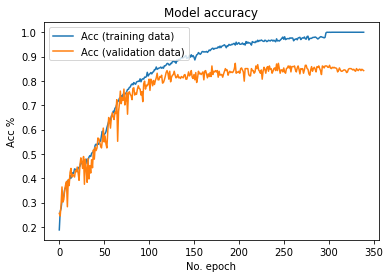

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **Validation Set Evaluation**

**Val Set Score**

In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

12/12 - 2s - loss: 0.5993 - categorical_accuracy: 0.8723


In [22]:
# Validation score
loss,acc = model3.evaluate(x_val, y_val_class, verbose=2)

8/8 - 0s - loss: 0.8574 - categorical_accuracy: 0.7400


**Val Set Confussion Matrix**

Text(0.5, 58.7222222222222, 'Predicted emotion')

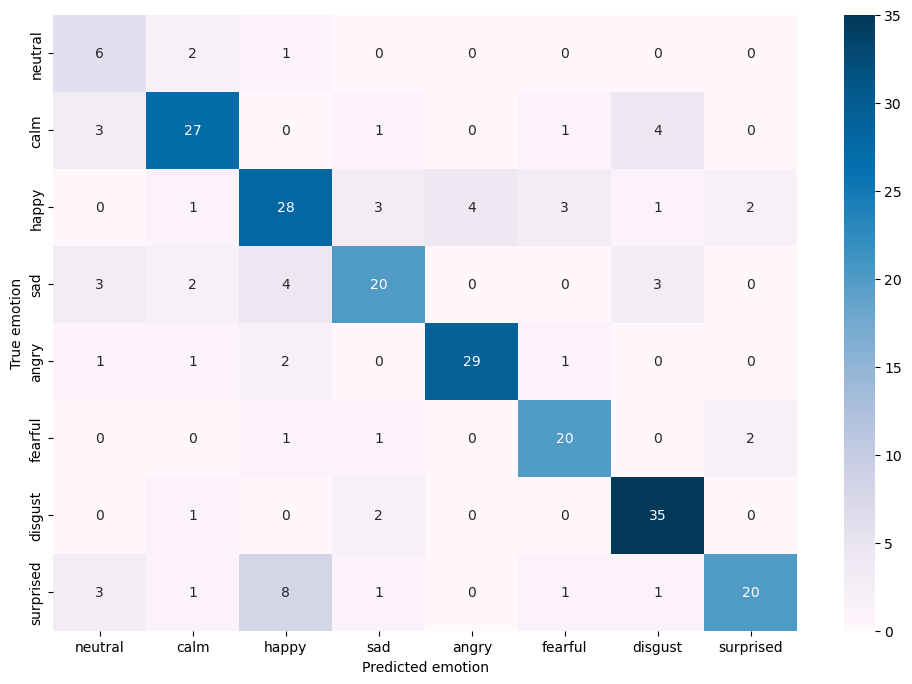

In [23]:
# Validation Confusion matrix
import pandas as pd
#y_val_class = np.argmax(y_val_class, axis=1)
yval=np.argmax(y_val_class, axis=1)
predictions = model3.predict(x_val)
#y_pred_class = np.argmax(predictions, axis=1)
ypred=np.argmax(predictions, axis=1)

#cm=confusion_matrix(y_val_class, y_pred_class)
cm=confusion_matrix(yval, ypred)
index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

Text(0.5, 51.0, 'Predicted emotion')

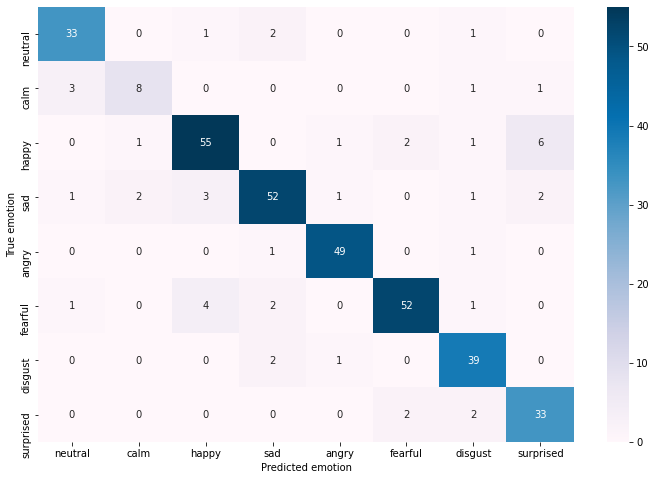

In [ ]:
# Validation Confusion matrix

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Validation Set Predicted emotions accuracy**

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.8919
calm : 0.6154
happy : 0.8333
sad : 0.8387
angry : 0.9608
fearful : 0.8667
disgust : 0.9286
surprised : 0.8919


In [24]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.6667
calm : 0.7500
happy : 0.6667
sad : 0.6250
angry : 0.8529
fearful : 0.8333
disgust : 0.9211
surprised : 0.5714


## **Save & Load model, weights**


In [27]:
# Saving model & weights

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

model_json = model3.to_json()
saved_model_path = 'model_ssd2.json'
saved_weights_path = 'model_wssd2.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model3.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


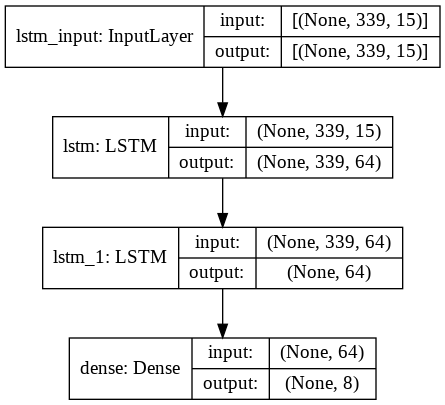

In [ ]:
# Reading the model from JSON file

saved_model_path = 'model_ssd2.json'
saved_weights_path = 'model_wssd2.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [28]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

## **Test Set Evaluation**

**Test Set Score**

In [30]:
loss, acc = model3.evaluate(x_test, y_test_class, verbose=2)

4/4 - 0s - loss: 1.1555 - categorical_accuracy: 0.6364


In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

6/6 - 1s - loss: 0.5561 - categorical_accuracy: 0.8447


**Test Set Confussion Matrix**

Text(0.5, 51.0, 'Predicted emotion')

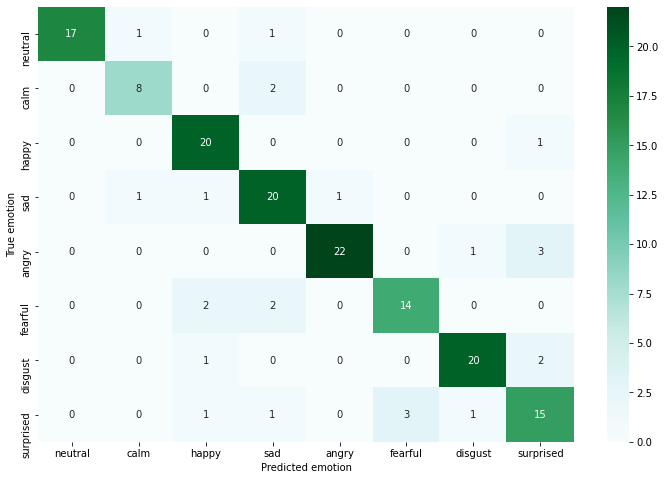

In [ ]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Test Set Predicted emotions accuracy**

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.8947
calm : 0.8000
happy : 0.9524
sad : 0.8696
angry : 0.8462
fearful : 0.7778
disgust : 0.8696
surprised : 0.7143


# **Trying different Architecture**
 

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 


# Initializing the model

model2 = Sequential()
model2.add(layers.LSTM(256, return_sequences = True, input_shape=(X.shape[1:3])))
model2.add(layers.LSTM(128, return_sequences = True))
model2.add(layers.LSTM(64, return_sequences = True))
model2.add(layers.LSTM(64))
model2.add(layers.Dense(8, activation = 'softmax'))
print(model2.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 339, 256)          278528    
_________________________________________________________________
lstm_9 (LSTM)                (None, 339, 128)          197120    
_________________________________________________________________
lstm_10 (LSTM)               (None, 339, 64)           49408     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 558,600
Trainable params: 558,600
Non-trainable params: 0
_________________________________________________________________
None


In [41]:

batch_size = 23

# Callbacks functions
checkpoint_path = 'sersid/best_weights_ssd3.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=150)
                             
# Compile & train   
model2.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history2 = model2.fit(x_train, y_train_class, 
                      epochs=200, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model2.load_weights(checkpoint_path)

Epoch 1/200
110/110 [==============================] - 22s 141ms/step - loss: 2.0441 - categorical_accuracy: 0.1782 - val_loss: 1.9514 - val_categorical_accuracy: 0.1960
Epoch 2/200
110/110 [==============================] - 15s 132ms/step - loss: 1.9622 - categorical_accuracy: 0.2196 - val_loss: 1.9951 - val_categorical_accuracy: 0.2080
Epoch 3/200
110/110 [==============================] - 14s 131ms/step - loss: 1.8818 - categorical_accuracy: 0.2633 - val_loss: 1.8865 - val_categorical_accuracy: 0.2520
Epoch 4/200
110/110 [==============================] - 15s 136ms/step - loss: 1.8307 - categorical_accuracy: 0.2940 - val_loss: 1.7973 - val_categorical_accuracy: 0.3080
Epoch 5/200
110/110 [==============================] - 14s 130ms/step - loss: 1.7823 - categorical_accuracy: 0.3079 - val_loss: 1.8682 - val_categorical_accuracy: 0.2520
Epoch 6/200
110/110 [==============================] - 14s 129ms/step - loss: 1.7392 - categorical_accuracy: 0.3381 - val_loss: 2.0796 - val_categoric

Epoch 49/200
110/110 [==============================] - 14s 131ms/step - loss: 0.7445 - categorical_accuracy: 0.7391 - val_loss: 1.0754 - val_categorical_accuracy: 0.6200
Epoch 50/200
110/110 [==============================] - 14s 129ms/step - loss: 0.7243 - categorical_accuracy: 0.7395 - val_loss: 1.0685 - val_categorical_accuracy: 0.6040
Epoch 51/200
110/110 [==============================] - 14s 128ms/step - loss: 0.7044 - categorical_accuracy: 0.7411 - val_loss: 1.1627 - val_categorical_accuracy: 0.6160
Epoch 52/200
110/110 [==============================] - 14s 126ms/step - loss: 0.6475 - categorical_accuracy: 0.7721 - val_loss: 1.0256 - val_categorical_accuracy: 0.6600
Epoch 53/200
110/110 [==============================] - 14s 128ms/step - loss: 0.6162 - categorical_accuracy: 0.7892 - val_loss: 1.1072 - val_categorical_accuracy: 0.6440
Epoch 54/200
110/110 [==============================] - 14s 128ms/step - loss: 0.6148 - categorical_accuracy: 0.7848 - val_loss: 1.0689 - val_cat

Epoch 97/200
110/110 [==============================] - 14s 128ms/step - loss: 0.2552 - categorical_accuracy: 0.9200 - val_loss: 0.5279 - val_categorical_accuracy: 0.8480
Epoch 98/200
110/110 [==============================] - 14s 126ms/step - loss: 0.2367 - categorical_accuracy: 0.9208 - val_loss: 0.6692 - val_categorical_accuracy: 0.7800
Epoch 99/200
110/110 [==============================] - 14s 127ms/step - loss: 0.2850 - categorical_accuracy: 0.9105 - val_loss: 0.5327 - val_categorical_accuracy: 0.8520
Epoch 100/200
110/110 [==============================] - 14s 128ms/step - loss: 0.2554 - categorical_accuracy: 0.9189 - val_loss: 1.0334 - val_categorical_accuracy: 0.7280
Epoch 101/200
110/110 [==============================] - 14s 128ms/step - loss: 0.2288 - categorical_accuracy: 0.9260 - val_loss: 0.4756 - val_categorical_accuracy: 0.8520
Epoch 102/200
110/110 [==============================] - 14s 130ms/step - loss: 0.2042 - categorical_accuracy: 0.9427 - val_loss: 0.5298 - val_

Epoch 145/200
110/110 [==============================] - 14s 128ms/step - loss: 0.1495 - categorical_accuracy: 0.9543 - val_loss: 0.7203 - val_categorical_accuracy: 0.8520
Epoch 146/200
110/110 [==============================] - 14s 128ms/step - loss: 0.1224 - categorical_accuracy: 0.9646 - val_loss: 0.6436 - val_categorical_accuracy: 0.8640
Epoch 147/200
110/110 [==============================] - 14s 126ms/step - loss: 0.1563 - categorical_accuracy: 0.9547 - val_loss: 0.6643 - val_categorical_accuracy: 0.8240
Epoch 148/200
110/110 [==============================] - 14s 128ms/step - loss: 0.1229 - categorical_accuracy: 0.9662 - val_loss: 0.5725 - val_categorical_accuracy: 0.8720
Epoch 149/200
110/110 [==============================] - 14s 126ms/step - loss: 0.1797 - categorical_accuracy: 0.9499 - val_loss: 0.5430 - val_categorical_accuracy: 0.8800
Epoch 150/200
110/110 [==============================] - 14s 128ms/step - loss: 0.1151 - categorical_accuracy: 0.9646 - val_loss: 0.4465 - v

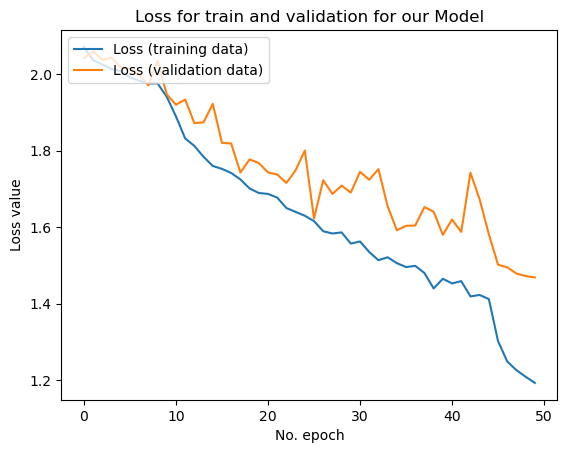

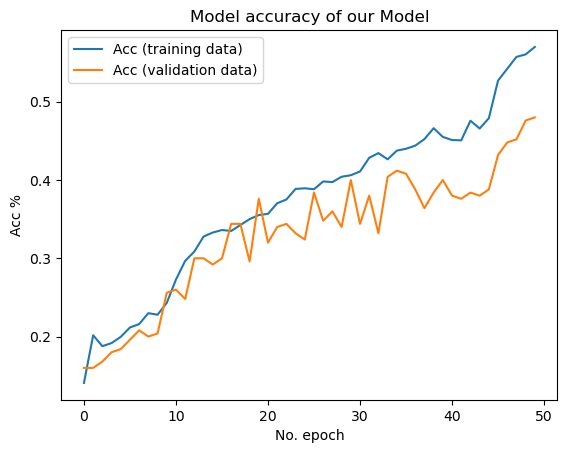

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation for our Model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy of our Model')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [44]:
# Validation score
loss,acc = model2.evaluate(x_val, y_val_class, verbose=2)

8/8 - 1s - loss: 0.3264 - categorical_accuracy: 0.9320


Text(0.5, 58.7222222222222, 'Predicted emotion')

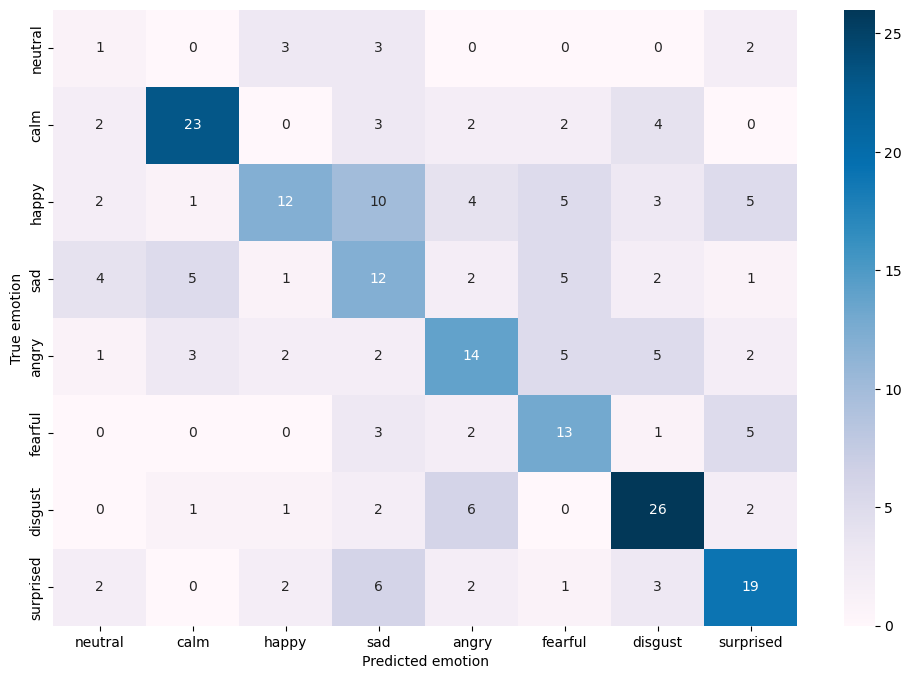

In [45]:
# Validation Confusion matrix
import pandas as pd
#y_val_class = np.argmax(y_val_class, axis=1)
yval=np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
#y_pred_class = np.argmax(predictions, axis=1)
ypred=np.argmax(predictions, axis=1)

#cm=confusion_matrix(y_val_class, y_pred_class)
cm=confusion_matrix(yval, ypred)
index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [66]:
ypred

array([1, 4, 5, 5, 2, 7, 2, 1, 4, 2, 7, 6, 5, 6, 7, 1, 3, 1, 2, 7, 6, 1,
       5, 2, 1, 2, 5, 3, 4, 1, 2, 7, 2, 2, 4, 3, 4, 1, 0, 4, 2, 1, 5, 1,
       4, 3, 5, 6, 7, 6, 2, 1, 3, 2, 0, 3, 6, 5, 4, 1, 6, 1, 5, 1, 0, 1,
       2, 3, 3, 6, 5, 7, 2, 6, 3, 2, 7, 6, 7, 2, 6, 4, 7, 6, 3, 3, 4, 6,
       6, 4, 1, 7, 6, 6, 1, 7, 3, 2, 2, 3, 2, 1, 4, 4, 4, 2, 2, 2, 7, 7,
       6, 6, 2, 3, 4, 3, 7, 3, 5, 5, 3, 5, 1, 5, 1, 5, 0, 6, 1, 1, 7, 2,
       6, 4, 4, 2, 6, 4, 7, 0, 4, 2, 7, 7, 7, 0, 4, 3, 3, 7, 4, 4, 3, 6,
       5, 5, 4, 3, 5, 6, 7, 2, 6, 4, 1, 4, 0, 1, 0, 4, 4, 7, 3, 5, 2, 5,
       7, 7, 2, 7, 2, 1, 1, 2, 6, 3, 7, 1, 7, 2, 7, 2, 6, 6, 1, 6, 7, 6,
       7, 5, 3, 6, 6, 3, 3, 3, 2, 5, 3, 6, 2, 2, 4, 3, 6, 2, 1, 6, 1, 1,
       7, 4, 3, 1, 4, 1, 7, 5, 5, 0, 5, 6, 2, 2, 6, 6, 7, 1, 3, 7, 3, 4,
       4, 3, 0, 5, 7, 2, 6, 1], dtype=int64)

In [46]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.1111
calm : 0.6389
happy : 0.2857
sad : 0.3750
angry : 0.4118
fearful : 0.5417
disgust : 0.6842
surprised : 0.5429


In [50]:
# Saving model & weights

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

model_json = model2.to_json()
saved_model_path = 'model_ssd3.json'
saved_weights_path = 'model_wssd3.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model2.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


In [51]:
# Reading the model from JSON file

saved_model_path = 'model_ssd3.json'
saved_weights_path = 'model_wssd3.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [52]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [54]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

4/4 - 0s - loss: 0.4951 - categorical_accuracy: 0.9000


# Test Set confusion Matrix

Text(0.5, 58.7222222222222, 'Predicted emotion')

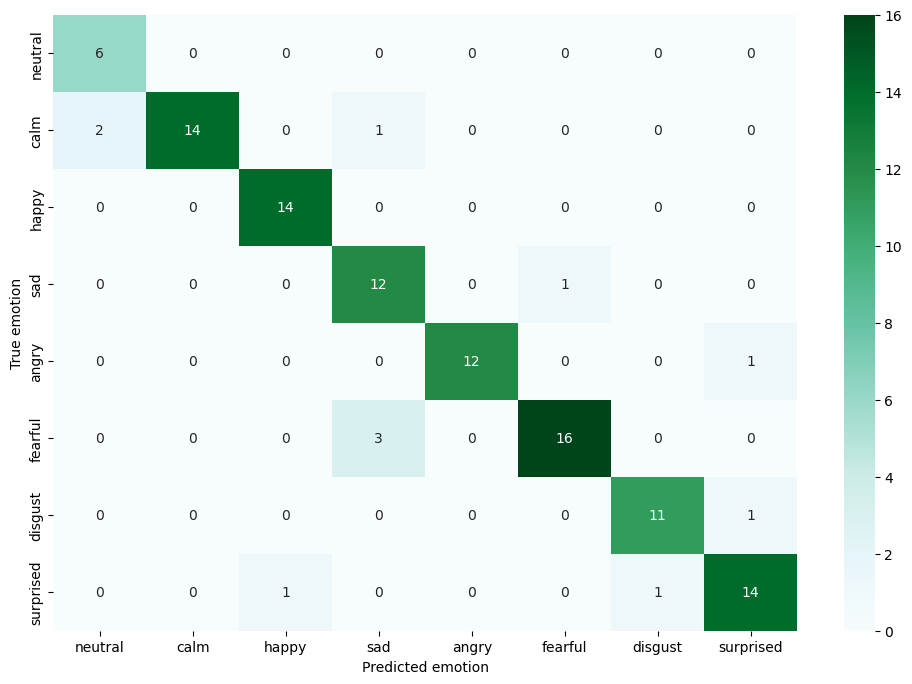

In [55]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [58]:

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

AxisError: axis 1 is out of bounds for array of dimension 1

In [60]:
import librosa
from librosa import display

data, sampling_rate = librosa.load(r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\SSD_Final_MusicEmotion\data\RAVDESS\Actor_03\03-01-01-01-01-01-03.wav")

In [64]:
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


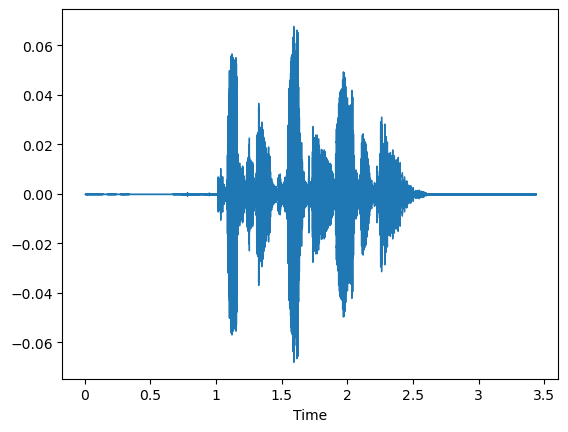

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [77]:
%pylab inline
import os
import pandas as pd
import glob 

librosa.display.waveshow(y=data, sr=sampling_rate)

In [79]:
import time

path = r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\SSD_Final_MusicEmotion\data\RAVDESS_SSD"
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 189.72781133651733 seconds ---


In [80]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [81]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2880, 40), (2880,))

In [82]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\SSD_Final_MusicEmotion\data\RAVDESS_SSD"


savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [83]:
# Loading saved models

X = joblib.load(r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\SSD_Final_MusicEmotion\data\RAVDESS_SSD\X.joblib")
y = joblib.load(r"C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE3506_ProZ_EDA\SSD_Final_MusicEmotion\data\RAVDESS_SSD\y.joblib")

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [85]:
from sklearn.tree import DecisionTreeClassifier

In [86]:
dtree = DecisionTreeClassifier()

dtree.fit(X_train, y_train)



DecisionTreeClassifier()

In [87]:
predictions = dtree.predict(X_test)

In [ ]:
"""
Let's go with our classification report.

Before we start, a quick reminder of the classes we are trying to predict:

emotions = {
    "neutral": "0",
    "calm": "1",
    "happy": "2",
    "sad": "3",
    "angry": "4", 
    "fearful": "5", 
    "disgust": "6", 
    "surprised": "7"
}
"""

In [88]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        73
           1       0.80      0.84      0.82       124
           2       0.82      0.73      0.77       135
           3       0.74      0.85      0.79       109
           4       0.87      0.82      0.84       112
           5       0.74      0.82      0.78       133
           6       0.80      0.80      0.80       133
           7       0.81      0.77      0.79       132

    accuracy                           0.80       951
   macro avg       0.80      0.80      0.80       951
weighted avg       0.80      0.80      0.80       951



# Random Forest

In this second approach, I switched to a random forest classifier and I made a gridsearch to make some hyperparameters tuning.

The gridsearch is not shown in the code below otherwise the notebook will require too much time to run.

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [91]:
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [92]:
predictions = rforest.predict(X_test)

In [93]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.26      0.41        73
           1       0.57      0.98      0.72       124
           2       0.81      0.67      0.74       135
           3       0.69      0.73      0.71       109
           4       0.85      0.88      0.86       112
           5       0.82      0.73      0.77       133
           6       0.83      0.77      0.80       133
           7       0.76      0.77      0.77       132

    accuracy                           0.75       951
   macro avg       0.79      0.72      0.72       951
weighted avg       0.78      0.75      0.74       951



## Trying with Entropy

In [94]:
rforest = RandomForestClassifier(criterion="entropy", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)
rforest.fit(X_train, y_train)
predictions = rforest.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.33      0.49        73
           1       0.58      0.99      0.73       124
           2       0.85      0.70      0.76       135
           3       0.80      0.79      0.79       109
           4       0.85      0.88      0.87       112
           5       0.84      0.77      0.80       133
           6       0.84      0.82      0.83       133
           7       0.82      0.80      0.81       132

    accuracy                           0.78       951
   macro avg       0.82      0.76      0.76       951
weighted avg       0.81      0.78      0.78       951



# Neural network


Let's build our neural network!

To do so, we need to expand the dimensions of our array, adding a third one using the numpy "expand_dims" feature.

In [104]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)



In [105]:
x_traincnn.shape, x_testcnn.shape

((1929, 40, 1), (951, 40, 1))

In [116]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

model4 = Sequential()

model4.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model4.add(Activation('relu'))
model4.add(Dropout(0.1))
model4.add(MaxPooling1D(pool_size=(8)))
model4.add(Conv1D(128, 5,padding='same',))
model4.add(Activation('relu'))
model4.add(Dropout(0.1))
model4.add(Flatten())
model4.add(Dense(8))
model4.add(Activation('softmax'))
import tensorflow
from tensorflow.keras import optimizers
opt = tensorflow.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
#optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [117]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_24 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
activation_25 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 128)           

In [118]:
model4.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [119]:
ssdhistory=model4.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
121/121 [==============================] - 21s 19ms/step - loss: 8.2805 - accuracy: 0.1353 - val_loss: 4.1244 - val_accuracy: 0.1651
Epoch 2/1000
121/121 [==============================] - 1s 10ms/step - loss: 6.9028 - accuracy: 0.1436 - val_loss: 2.3818 - val_accuracy: 0.1672
Epoch 3/1000
121/121 [==============================] - 1s 11ms/step - loss: 5.8152 - accuracy: 0.1659 - val_loss: 3.2579 - val_accuracy: 0.1893
Epoch 4/1000
121/121 [==============================] - 1s 10ms/step - loss: 5.0381 - accuracy: 0.1638 - val_loss: 2.8173 - val_accuracy: 0.1483
Epoch 5/1000
121/121 [==============================] - 1s 10ms/step - loss: 4.3359 - accuracy: 0.1752 - val_loss: 2.4596 - val_accuracy: 0.2324
Epoch 6/1000
121/121 [==============================] - 1s 10ms/step - loss: 3.8248 - accuracy: 0.1877 - val_loss: 1.9557 - val_accuracy: 0.2639
Epoch 7/1000
121/121 [==============================] - 1s 11ms/step - loss: 3.3068 - accuracy: 0.1773 - val_loss: 1.9116 - val_a

121/121 [==============================] - 1s 10ms/step - loss: 1.2320 - accuracy: 0.5588 - val_loss: 1.3108 - val_accuracy: 0.5405
Epoch 114/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.2284 - accuracy: 0.5640 - val_loss: 1.3487 - val_accuracy: 0.4995
Epoch 115/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.2242 - accuracy: 0.5542 - val_loss: 1.3200 - val_accuracy: 0.5195
Epoch 116/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.2218 - accuracy: 0.5521 - val_loss: 1.3178 - val_accuracy: 0.5247
Epoch 117/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.2255 - accuracy: 0.5500 - val_loss: 1.3290 - val_accuracy: 0.5163
Epoch 118/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.2024 - accuracy: 0.5713 - val_loss: 1.3194 - val_accuracy: 0.5089
Epoch 119/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.1965 - accuracy: 0.5640 - val_loss: 1.2970 - val_acc

Epoch 169/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.0031 - accuracy: 0.6464 - val_loss: 1.1407 - val_accuracy: 0.6130
Epoch 170/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.9784 - accuracy: 0.6625 - val_loss: 1.1340 - val_accuracy: 0.6162
Epoch 171/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.0061 - accuracy: 0.6470 - val_loss: 1.1290 - val_accuracy: 0.6172
Epoch 172/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.9784 - accuracy: 0.6537 - val_loss: 1.1712 - val_accuracy: 0.5910
Epoch 173/1000
121/121 [==============================] - 1s 10ms/step - loss: 1.0007 - accuracy: 0.6423 - val_loss: 1.1290 - val_accuracy: 0.6204
Epoch 174/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.9927 - accuracy: 0.6522 - val_loss: 1.1520 - val_accuracy: 0.6099
Epoch 175/1000
121/121 [==============================] - 1s 11ms/step - loss: 0.9625 - accuracy: 0.6630 - val_loss: 1

Epoch 225/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.8281 - accuracy: 0.7133 - val_loss: 1.0207 - val_accuracy: 0.6614
Epoch 226/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.8268 - accuracy: 0.7071 - val_loss: 1.0331 - val_accuracy: 0.6435
Epoch 227/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.8196 - accuracy: 0.7206 - val_loss: 1.0493 - val_accuracy: 0.6519
Epoch 228/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.8149 - accuracy: 0.7237 - val_loss: 1.0398 - val_accuracy: 0.6393
Epoch 229/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.8188 - accuracy: 0.7128 - val_loss: 1.0244 - val_accuracy: 0.6688
Epoch 230/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.8108 - accuracy: 0.7247 - val_loss: 1.0404 - val_accuracy: 0.6488
Epoch 231/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.8015 - accuracy: 0.7346 - val_loss: 1

Epoch 281/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.6971 - accuracy: 0.7579 - val_loss: 0.9168 - val_accuracy: 0.7119
Epoch 282/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.6819 - accuracy: 0.7600 - val_loss: 0.9179 - val_accuracy: 0.7003
Epoch 283/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.6970 - accuracy: 0.7553 - val_loss: 0.8992 - val_accuracy: 0.7234
Epoch 284/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.6696 - accuracy: 0.7740 - val_loss: 0.9221 - val_accuracy: 0.7024
Epoch 285/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.6946 - accuracy: 0.7729 - val_loss: 0.9035 - val_accuracy: 0.7077
Epoch 286/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.6792 - accuracy: 0.7667 - val_loss: 0.9171 - val_accuracy: 0.7003
Epoch 287/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.6493 - accuracy: 0.7843 - val_loss: 0

Epoch 337/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.5879 - accuracy: 0.8035 - val_loss: 0.8118 - val_accuracy: 0.7371
Epoch 338/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.5617 - accuracy: 0.8212 - val_loss: 0.8220 - val_accuracy: 0.7539
Epoch 339/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.5684 - accuracy: 0.8123 - val_loss: 0.8842 - val_accuracy: 0.7098
Epoch 340/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.5556 - accuracy: 0.8092 - val_loss: 0.8385 - val_accuracy: 0.7245
Epoch 341/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.5809 - accuracy: 0.8129 - val_loss: 0.8297 - val_accuracy: 0.7571
Epoch 342/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.5543 - accuracy: 0.8113 - val_loss: 0.8714 - val_accuracy: 0.7150
Epoch 343/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.5638 - accuracy: 0.8165 - val_loss: 0

Epoch 393/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.4494 - accuracy: 0.8533 - val_loss: 0.7759 - val_accuracy: 0.7844
Epoch 394/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.4770 - accuracy: 0.8440 - val_loss: 0.7729 - val_accuracy: 0.7560
Epoch 395/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.4673 - accuracy: 0.8440 - val_loss: 0.7625 - val_accuracy: 0.7718
Epoch 396/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.4754 - accuracy: 0.8367 - val_loss: 0.7598 - val_accuracy: 0.7865
Epoch 397/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.4781 - accuracy: 0.8388 - val_loss: 0.7486 - val_accuracy: 0.7729
Epoch 398/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.4684 - accuracy: 0.8486 - val_loss: 0.7727 - val_accuracy: 0.7771
Epoch 399/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.4751 - accuracy: 0.8440 - val_loss: 0

Epoch 449/1000
121/121 [==============================] - 1s 11ms/step - loss: 0.3795 - accuracy: 0.8771 - val_loss: 0.7211 - val_accuracy: 0.8044
Epoch 450/1000
121/121 [==============================] - 1s 11ms/step - loss: 0.4182 - accuracy: 0.8616 - val_loss: 0.6962 - val_accuracy: 0.8202
Epoch 451/1000
121/121 [==============================] - 1s 11ms/step - loss: 0.3951 - accuracy: 0.8725 - val_loss: 0.7132 - val_accuracy: 0.7865
Epoch 452/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3950 - accuracy: 0.8683 - val_loss: 0.6959 - val_accuracy: 0.7950
Epoch 453/1000
121/121 [==============================] - 1s 11ms/step - loss: 0.4197 - accuracy: 0.8580 - val_loss: 0.7074 - val_accuracy: 0.8149
Epoch 454/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3955 - accuracy: 0.8740 - val_loss: 0.7017 - val_accuracy: 0.8002
Epoch 455/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3978 - accuracy: 0.8699 - val_loss: 0

Epoch 505/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3480 - accuracy: 0.8792 - val_loss: 0.6583 - val_accuracy: 0.8254
Epoch 506/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3363 - accuracy: 0.8927 - val_loss: 0.6555 - val_accuracy: 0.8202
Epoch 507/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3377 - accuracy: 0.8891 - val_loss: 0.6462 - val_accuracy: 0.8307
Epoch 508/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3231 - accuracy: 0.9010 - val_loss: 0.6349 - val_accuracy: 0.8370
Epoch 509/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3292 - accuracy: 0.8896 - val_loss: 0.6650 - val_accuracy: 0.8223
Epoch 510/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3319 - accuracy: 0.8922 - val_loss: 0.6655 - val_accuracy: 0.8013
Epoch 511/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.3444 - accuracy: 0.8906 - val_loss: 0

Epoch 561/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2963 - accuracy: 0.9098 - val_loss: 0.6283 - val_accuracy: 0.8538
Epoch 562/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2885 - accuracy: 0.9119 - val_loss: 0.6296 - val_accuracy: 0.8559
Epoch 563/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2846 - accuracy: 0.9067 - val_loss: 0.6098 - val_accuracy: 0.8465
Epoch 564/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2955 - accuracy: 0.9072 - val_loss: 0.6082 - val_accuracy: 0.8328
Epoch 565/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2774 - accuracy: 0.9124 - val_loss: 0.6009 - val_accuracy: 0.8496
Epoch 566/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2926 - accuracy: 0.9057 - val_loss: 0.6073 - val_accuracy: 0.8538
Epoch 567/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2766 - accuracy: 0.9176 - val_loss: 0

Epoch 617/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2657 - accuracy: 0.9207 - val_loss: 0.6018 - val_accuracy: 0.8465
Epoch 618/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2528 - accuracy: 0.9228 - val_loss: 0.6104 - val_accuracy: 0.8528
Epoch 619/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2467 - accuracy: 0.9243 - val_loss: 0.6004 - val_accuracy: 0.8570
Epoch 620/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2401 - accuracy: 0.9269 - val_loss: 0.6055 - val_accuracy: 0.8591
Epoch 621/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2435 - accuracy: 0.9165 - val_loss: 0.5912 - val_accuracy: 0.8759
Epoch 622/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2343 - accuracy: 0.9305 - val_loss: 0.6354 - val_accuracy: 0.8360
Epoch 623/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2627 - accuracy: 0.9129 - val_loss: 0

Epoch 673/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2104 - accuracy: 0.9326 - val_loss: 0.5999 - val_accuracy: 0.8601
Epoch 674/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2335 - accuracy: 0.9279 - val_loss: 0.5935 - val_accuracy: 0.8591
Epoch 675/1000
121/121 [==============================] - 3s 22ms/step - loss: 0.2353 - accuracy: 0.9233 - val_loss: 0.5889 - val_accuracy: 0.8717
Epoch 676/1000
121/121 [==============================] - 3s 28ms/step - loss: 0.2272 - accuracy: 0.9290 - val_loss: 0.5875 - val_accuracy: 0.8654
Epoch 677/1000
121/121 [==============================] - 1s 12ms/step - loss: 0.2090 - accuracy: 0.9383 - val_loss: 0.5718 - val_accuracy: 0.8780
Epoch 678/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2240 - accuracy: 0.9295 - val_loss: 0.5984 - val_accuracy: 0.8423
Epoch 679/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2240 - accuracy: 0.9305 - val_loss: 0

Epoch 729/1000
121/121 [==============================] - 1s 11ms/step - loss: 0.1961 - accuracy: 0.9331 - val_loss: 0.5301 - val_accuracy: 0.8854
Epoch 730/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1936 - accuracy: 0.9378 - val_loss: 0.5384 - val_accuracy: 0.8675
Epoch 731/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1931 - accuracy: 0.9404 - val_loss: 0.5841 - val_accuracy: 0.8749
Epoch 732/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1905 - accuracy: 0.9430 - val_loss: 0.5687 - val_accuracy: 0.8707
Epoch 733/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1899 - accuracy: 0.9383 - val_loss: 0.5380 - val_accuracy: 0.8822
Epoch 734/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.2077 - accuracy: 0.9342 - val_loss: 0.5908 - val_accuracy: 0.8633
Epoch 735/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1987 - accuracy: 0.9425 - val_loss: 0

Epoch 785/1000
121/121 [==============================] - 2s 13ms/step - loss: 0.1629 - accuracy: 0.9513 - val_loss: 0.5926 - val_accuracy: 0.8665
Epoch 786/1000
121/121 [==============================] - 1s 12ms/step - loss: 0.1726 - accuracy: 0.9425 - val_loss: 0.5707 - val_accuracy: 0.8749
Epoch 787/1000
121/121 [==============================] - 1s 12ms/step - loss: 0.1625 - accuracy: 0.9440 - val_loss: 0.5408 - val_accuracy: 0.8843
Epoch 788/1000
121/121 [==============================] - 2s 13ms/step - loss: 0.1845 - accuracy: 0.9393 - val_loss: 0.5550 - val_accuracy: 0.8728
Epoch 789/1000
121/121 [==============================] - 2s 13ms/step - loss: 0.1778 - accuracy: 0.9456 - val_loss: 0.5600 - val_accuracy: 0.8738
Epoch 790/1000
121/121 [==============================] - 2s 13ms/step - loss: 0.1614 - accuracy: 0.9492 - val_loss: 0.5347 - val_accuracy: 0.8812
Epoch 791/1000
121/121 [==============================] - 1s 12ms/step - loss: 0.1652 - accuracy: 0.9502 - val_loss: 0

Epoch 841/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1544 - accuracy: 0.9523 - val_loss: 0.5263 - val_accuracy: 0.8843
Epoch 842/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1390 - accuracy: 0.9596 - val_loss: 0.5571 - val_accuracy: 0.8686
Epoch 843/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1519 - accuracy: 0.9482 - val_loss: 0.5583 - val_accuracy: 0.8833
Epoch 844/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1561 - accuracy: 0.9492 - val_loss: 0.5641 - val_accuracy: 0.8780
Epoch 845/1000
121/121 [==============================] - 1s 9ms/step - loss: 0.1671 - accuracy: 0.9414 - val_loss: 0.5503 - val_accuracy: 0.8749
Epoch 846/1000
121/121 [==============================] - 1s 9ms/step - loss: 0.1592 - accuracy: 0.9580 - val_loss: 0.5678 - val_accuracy: 0.8864
Epoch 847/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1426 - accuracy: 0.9523 - val_loss: 0.5

Epoch 897/1000
121/121 [==============================] - 1s 12ms/step - loss: 0.1402 - accuracy: 0.9627 - val_loss: 0.5286 - val_accuracy: 0.8906
Epoch 898/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1402 - accuracy: 0.9570 - val_loss: 0.5780 - val_accuracy: 0.8801
Epoch 899/1000
121/121 [==============================] - 1s 10ms/step - loss: 0.1321 - accuracy: 0.9601 - val_loss: 0.5647 - val_accuracy: 0.8759
Epoch 900/1000
121/121 [==============================] - 1s 12ms/step - loss: 0.1351 - accuracy: 0.9539 - val_loss: 0.5434 - val_accuracy: 0.8854
Epoch 901/1000
121/121 [==============================] - 2s 14ms/step - loss: 0.1407 - accuracy: 0.9528 - val_loss: 0.5747 - val_accuracy: 0.8780
Epoch 902/1000
121/121 [==============================] - 2s 13ms/step - loss: 0.1238 - accuracy: 0.9590 - val_loss: 0.5691 - val_accuracy: 0.8885
Epoch 903/1000
121/121 [==============================] - 2s 13ms/step - loss: 0.1349 - accuracy: 0.9585 - val_loss: 0

Epoch 953/1000
121/121 [==============================] - 1s 9ms/step - loss: 0.1201 - accuracy: 0.9601 - val_loss: 0.5410 - val_accuracy: 0.8843
Epoch 954/1000
121/121 [==============================] - 1s 8ms/step - loss: 0.1277 - accuracy: 0.9590 - val_loss: 0.5695 - val_accuracy: 0.8791
Epoch 955/1000
121/121 [==============================] - 1s 8ms/step - loss: 0.1199 - accuracy: 0.9622 - val_loss: 0.5470 - val_accuracy: 0.8791
Epoch 956/1000
121/121 [==============================] - 1s 7ms/step - loss: 0.1204 - accuracy: 0.9627 - val_loss: 0.5371 - val_accuracy: 0.8896
Epoch 957/1000
121/121 [==============================] - 1s 7ms/step - loss: 0.1195 - accuracy: 0.9596 - val_loss: 0.5715 - val_accuracy: 0.8885
Epoch 958/1000
121/121 [==============================] - 1s 7ms/step - loss: 0.1380 - accuracy: 0.9559 - val_loss: 0.5233 - val_accuracy: 0.9001
Epoch 959/1000
121/121 [==============================] - 1s 7ms/step - loss: 0.1337 - accuracy: 0.9539 - val_loss: 0.5361 -

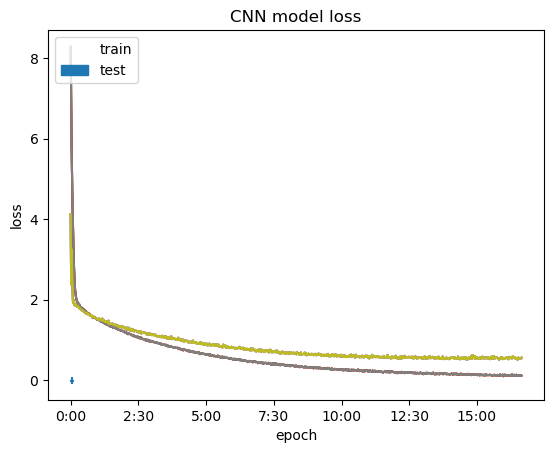

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [124]:
plt.plot(ssdhistory.history['loss'])
plt.plot(ssdhistory.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

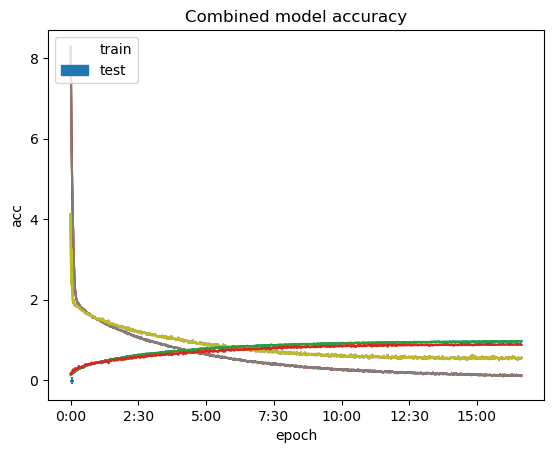

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [129]:
plt.plot(ssdhistory.history['accuracy'])
plt.plot(ssdhistory.history['val_accuracy'])
plt.title('Combined model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [139]:
predictions = model4.predict_classes(x_testcnn)
predictions[:10]

array([6, 2, 5, 5, 2, 7, 6, 4, 6, 0], dtype=int64)

In [138]:
y_test[:10]

array([6, 2, 5, 5, 2, 7, 6, 4, 6, 0])

In [140]:
new_Ytest = y_test.astype(int)
new_Ytest[:10]

array([6, 2, 5, 5, 2, 7, 6, 4, 6, 0])

In [141]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.68      0.77        73
           1       0.85      0.94      0.89       124
           2       0.88      0.84      0.86       135
           3       0.94      0.83      0.88       109
           4       0.82      0.93      0.87       112
           5       0.88      0.92      0.90       133
           6       0.92      0.91      0.91       133
           7       0.89      0.89      0.89       132

    accuracy                           0.88       951
   macro avg       0.88      0.87      0.87       951
weighted avg       0.88      0.88      0.88       951



In [142]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[ 50   9   2   4   0   0   3   5]
 [  2 116   2   0   0   2   2   0]
 [  0   0 114   0   9  10   0   2]
 [  1   6   2  90   0   4   2   4]
 [  2   0   2   0 104   0   4   0]
 [  0   2   4   2   0 123   0   2]
 [  0   2   0   0   8   0 121   2]
 [  2   2   4   0   6   0   0 118]]


In [146]:
model_name = 'Emotion_Voice_Detection_Model_.h5'
save_dir = 'data'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model4.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at data\Emotion_Voice_Detection_Model_.h5 


In [148]:
loaded_model = tensorflow.keras.models.load_model('/data/Emotion_Voice_Detection_Model_.h5')
loaded_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_24 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
activation_25 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 128)           

In [149]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

30/30 [==============================] - 0s 6ms/step - loss: 0.5594 - accuracy: 0.8791
Restored model, accuracy: 87.91%


# **RESULTS & CONCLUSIONS**

In [ ]:
As seen, the validation set accuracy of the model had come up to 87.23% and the test set accuracy had reached 84.47% with overfitting in the training process starting around the 100th epoch. Although various regulations have been placed in earlier tryouts, they had restricted the accuracy from reaching its maximum value. A ModelCheckpoint is applied, saving the best weights according to the model's accuracy, thus the overfitting is bypassed. 

Within the next part of the study in which the model will be used as a Real-time SER, The inputs will be processed similarly as the data used by the model, to gain similarity and therefore, precision.